In [1]:
!pip install imutils -q

In [2]:
import argparse
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored

from imutils import contours
from PIL import Image as Img
from IPython.display import Image
from skimage import measure

from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_csv("../input/ultra-mnist/train.csv") 
test_df = pd.read_csv("../input/ultra-mnist/sample_submission.csv") 

In [4]:
img_id = 'flzibxgfvd'

image = cv2.imread(f"../input/ultramnistblack/train/{img_id}.jpeg", 0)
image_oryg = cv2.imread(f"../input/ultra-mnist/train/{img_id}.jpeg", 0)

train_df.query("id == @img_id")

,id,digit_sum
5055,flzibxgfvd,13


In [5]:
def img_thresh(img_in):
    blurred = cv2.GaussianBlur(img_in, (11, 11), 0) #(11,11)
    thresh = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY)[1]
    #thresh = cv2.erode(thresh, None, iterations=2)
    #thresh = cv2.dilate(thresh, None, iterations=4)
    
    return thresh

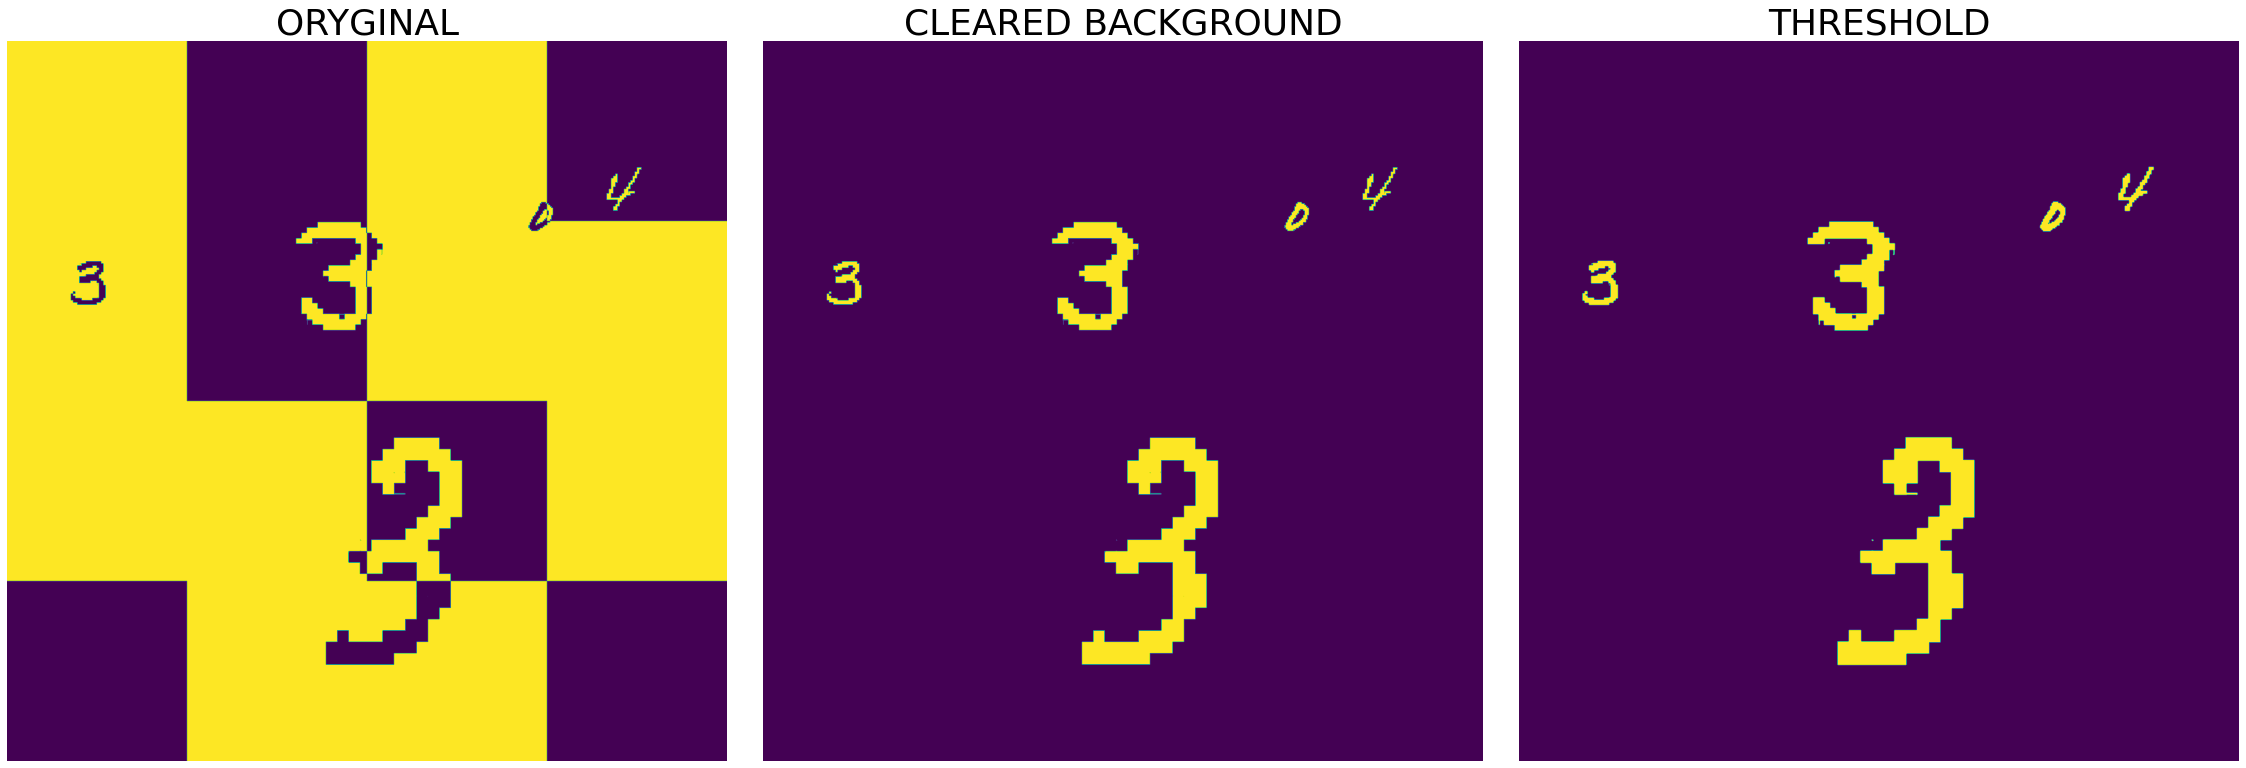

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(40,50))

axes[0].imshow(Img.fromarray(image_oryg))
axes[0].axis('off')
axes[0].set_title("ORYGINAL", fontsize=36)
axes[1].imshow(Img.fromarray(image))
axes[1].axis('off')
axes[1].set_title("CLEARED BACKGROUND", fontsize=36)
axes[2].imshow(Img.fromarray(img_thresh(image)))
axes[2].axis('off')
axes[2].set_title("THRESHOLD", fontsize=36)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.axis('off')
plt.show()

In [7]:
def mask_img(img_in):
    labels = measure.label(img_in,background = 0)
    mask = np.zeros(img_in.shape, dtype="uint8")

    for label in np.unique(labels):
        if label == 0:
            continue

        labelMask = np.zeros(img_in.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        if numPixels > 100:
            mask = cv2.add(mask, labelMask)
    return mask

In [8]:
mask = mask_img(img_thresh(image))

In [9]:
def find_cont(img_in, mask, debug = False, draw = False):
    bbox_list = []
    backtorgb = None

    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = contours.sort_contours(cnts)[0]
    if debug:
        print(f'Found {len(cnts)} contours / numbers')
        backtorgb = cv2.cvtColor(img_in.astype('float32'), cv2.COLOR_GRAY2RGB)

    for (i, c) in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        bbox_list.append([x, y, w, h])
        if draw:
            cv2.rectangle(backtorgb, (x,y), (x+w, y+h), (255,0,0), 5)

    if debug:
        print(f'BBoxes coordinates: {bbox_list}')
    return bbox_list, backtorgb

In [10]:
bbox_list, backtorgb = find_cont(image, mask, debug = True, draw = True)

Found 5 contours / numbers
BBoxes coordinates: [[352, 1221, 198, 246], [1603, 1003, 486, 606], [1769, 2201, 762, 1266], [2894, 892, 142, 166], [3329, 699, 198, 246]]


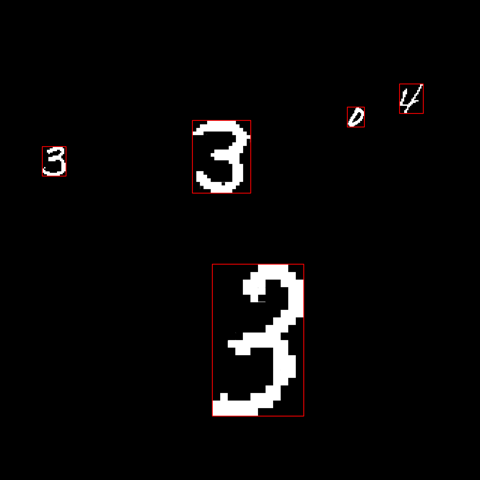

In [11]:
display(Img.fromarray(backtorgb.astype(np.uint8)).resize((480,480)))

In [12]:
def mnist_numbers(img_in, bbox_list, display_img = False):    
    # To look digits MNIST like I introduced margin and converted to 28x28
    offset = 5
    IMG_SIZE = 28

    numbers = []

    for bbox in bbox_list:
                   
        bbox_img = img_in[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
        h, w = bbox_img.shape
        
        if bbox[3] > bbox[2]:
            scale = bbox[3]
            offset_w = int((scale - w) / 2)
            offset_h = 0
        else:
            scale = bbox[2]
            offset_h = int((scale - h) / 2)
            offset_w = 0
        
        canvas = np.zeros((scale, scale))
        canvas[0+offset_h:h+offset_h, 0+offset_w:w+offset_w] = bbox_img
        
        bbox_resized = cv2.resize(canvas, (IMG_SIZE - 2 * offset, IMG_SIZE - 2 * offset), interpolation = cv2.INTER_AREA)    
        
        letterbox = np.zeros((IMG_SIZE, IMG_SIZE))
        letterbox[offset:IMG_SIZE-offset, offset:IMG_SIZE-offset] = bbox_resized
        numbers.append(letterbox)
        
        if display_img:
            display(Img.fromarray((letterbox).astype(np.uint8)))
    
    return numbers

In [13]:
numbers = mnist_numbers(image, bbox_list, display_img = True)

In [14]:
# Full pipeline
mask = mask_img(img_thresh(image))
bbox_list, backtorgb = find_cont(image, mask)
numbers = mnist_numbers(image, bbox_list, display_img = True)

## stop

In [15]:
import os
paths0=[]
for dirname, _, filenames in os.walk('../input/ultra-mnist/train'):
    for filename in filenames:
        paths0+=[os.path.join(dirname, filename)]
paths=sorted(paths0)
print(paths[:4])

['../input/ultra-mnist/train/aabwhmwmfo.jpeg', '../input/ultra-mnist/train/aadicdwvxv.jpeg', '../input/ultra-mnist/train/aadsfpjyjd.jpeg', '../input/ultra-mnist/train/aafocvcywl.jpeg']


In [16]:
a = pd.read_csv("../input/ultra-mnist/train.csv")
a=a.sort_values(by=["id"])
a.head(2)

,id,digit_sum
7508,aabwhmwmfo,25
25238,aadicdwvxv,4


In [17]:
def get_pieces(img_path):
    image = cv2.imread(img_path, 0)
    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    labels = measure.label(thresh,background = 0)
    mask = np.zeros(thresh.shape, dtype="uint8")

    for label in np.unique(labels):
        if label == 0:
            continue

        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        if numPixels > 300:
            mask = cv2.add(mask, labelMask)
    
    bbox_list = []

    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = contours.sort_contours(cnts)[0]
    print(f'Found {len(cnts)} contours / numbers')
    backtorgb = cv2.cvtColor(image.astype('float32'), cv2.COLOR_GRAY2RGB)

    for (i, c) in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        bbox_list.append([x, y, w, h])
        cv2.rectangle(backtorgb, (x,y), (x+w, y+h), (255,0,0), 5)

    print(f'BBoxes coordinates: {bbox_list}')
    
    verbose= 0
    for bbox in bbox_list:
        bbox_img = image[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
        bbox_resized = cv2.resize(bbox_img, (32,32), interpolation = cv2.INTER_AREA)

        # bbox_resized is my Image 
        dj = bbox_resized
        called_No = 0
        x1 = 0
        y1 = 0
        print("Got Value:")
        HOME = Optimize_CS(bbox_resized)
        # Calculate path cost
        img_mask = bbox_resized
        optimal_value,optimal_policy = Calculate_optimal(Grid_shape,no_actions, HOME,img_mask)
        if verbose != 0:
            sns.heatmap(optimal_value)
            plt.show()
            new_value = (optimal_value-np.min(optimal_value))/(np.max(optimal_value)-np.min(optimal_value))
            pd.DataFrame(new_value).iplot(kind='surface',)
        print(optimal_value[0,0], optimal_value[-1,0], optimal_value[0,-1], optimal_value[-1,-1], "sum: ",optimal_value[0,0]+ optimal_value[-1,0]+optimal_value[0,-1]+ optimal_value[-1,-1] )
        #break
        """
        #AGENT
        FROM = [(0,0),(31,0),(0,31),(31,31)]
        total_sum = 0
        for i in range(4):
            AGENT = FROM[i]

            #smart_trace()
            new_value = (optimal_value-np.min(optimal_value))/(np.max(optimal_value)-np.min(optimal_value))
            pd.DataFrame(new_value).iplot(kind='surface',)
        print("Net")
        print(total_sum)
        """



        display(Img.fromarray((bbox_resized).astype(np.uint8)))
        print("="*40)

In [18]:
image = cv2.imread("../input/ultramnistblack/train/aageiauxqt.jpeg", 0) #'flzibxgfvd'
image = cv2.imread("../input/ultramnistblack/train/aabwhmwmfo.jpeg", 0) #'flzibxgfvd' # They should be same why give different results
for p in paths:
    image = cv2.imread("../input/ultramnistblack/train/aabwhmwmfo.jpeg",0) #aabwhmwmfo.jpeg",0)
    break
#image = cv2.imread(paths[0], 0)

In [19]:
image = cv2.imread("../input/ultramnistblack/train/aabwhmwmfo.jpeg",0)

In [20]:
import os
paths0=[]
for dirname, _, filenames in os.walk('../input/ultramnistblack/train'):
    for filename in filenames:
        paths0+=[os.path.join(dirname, filename)]
paths2=sorted(paths0)
print(paths2[:4])

['../input/ultramnistblack/train/aabwhmwmfo.jpeg', '../input/ultramnistblack/train/aadicdwvxv.jpeg', '../input/ultramnistblack/train/aadsfpjyjd.jpeg', '../input/ultramnistblack/train/aafocvcywl.jpeg']


In [21]:
len(paths), len(paths2)

(28000, 28000)

In [22]:
image = cv2.imread(paths[1],0)

In [23]:
paths[:3]

['../input/ultra-mnist/train/aabwhmwmfo.jpeg',
 '../input/ultra-mnist/train/aadicdwvxv.jpeg',
 '../input/ultra-mnist/train/aadsfpjyjd.jpeg']

In [24]:
blurred = cv2.GaussianBlur(image, (11, 11), 0)
thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=4)

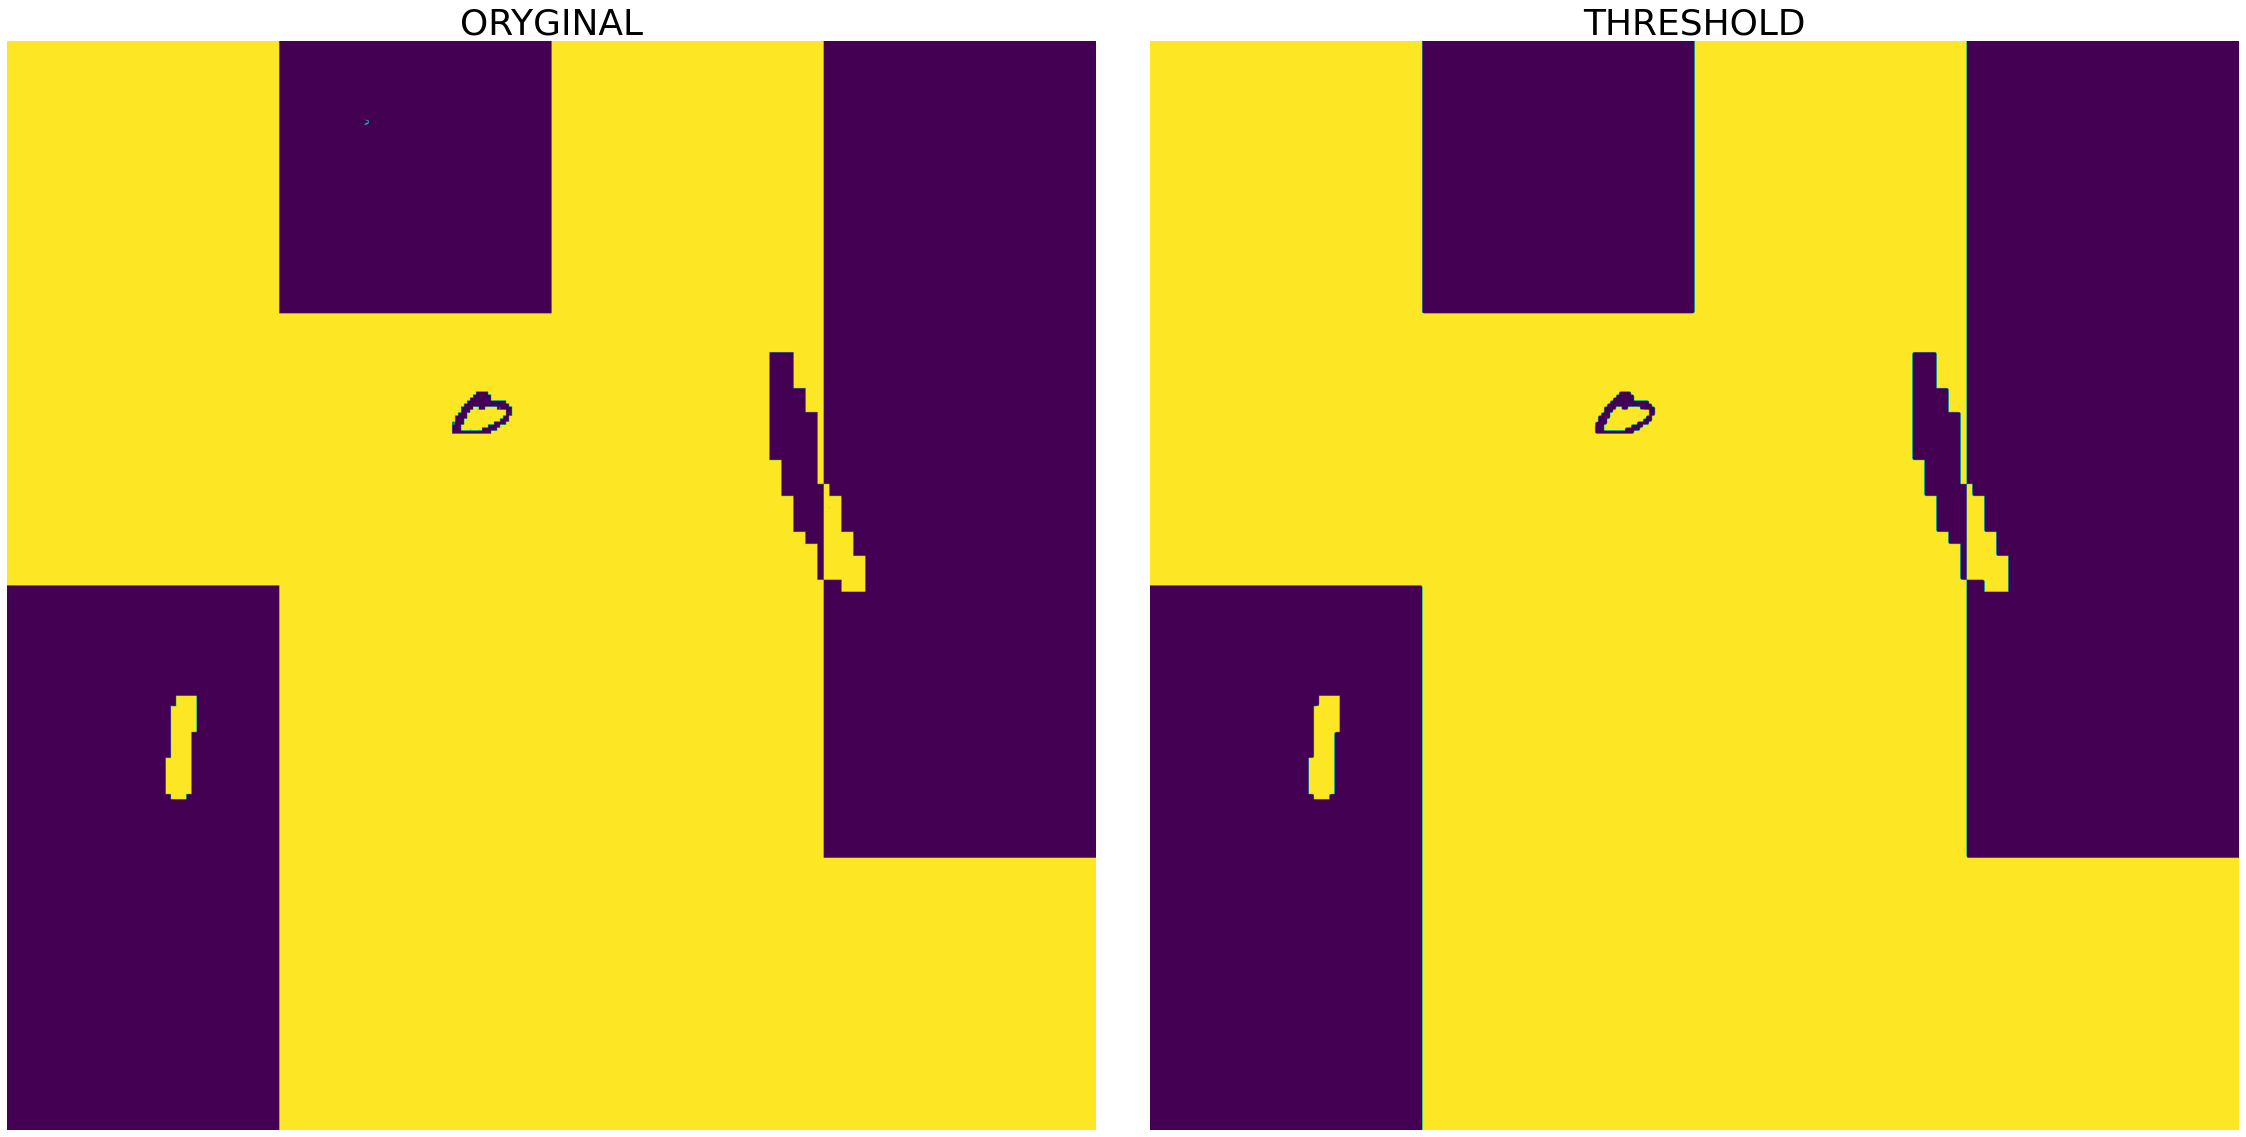

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(40,50))

axes[0].imshow(Img.fromarray(image))
axes[0].axis('off')
axes[0].set_title("ORYGINAL", fontsize=36)
axes[1].imshow(Img.fromarray(thresh))
axes[1].axis('off')
axes[1].set_title("THRESHOLD", fontsize=36)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.axis('off')
plt.show()

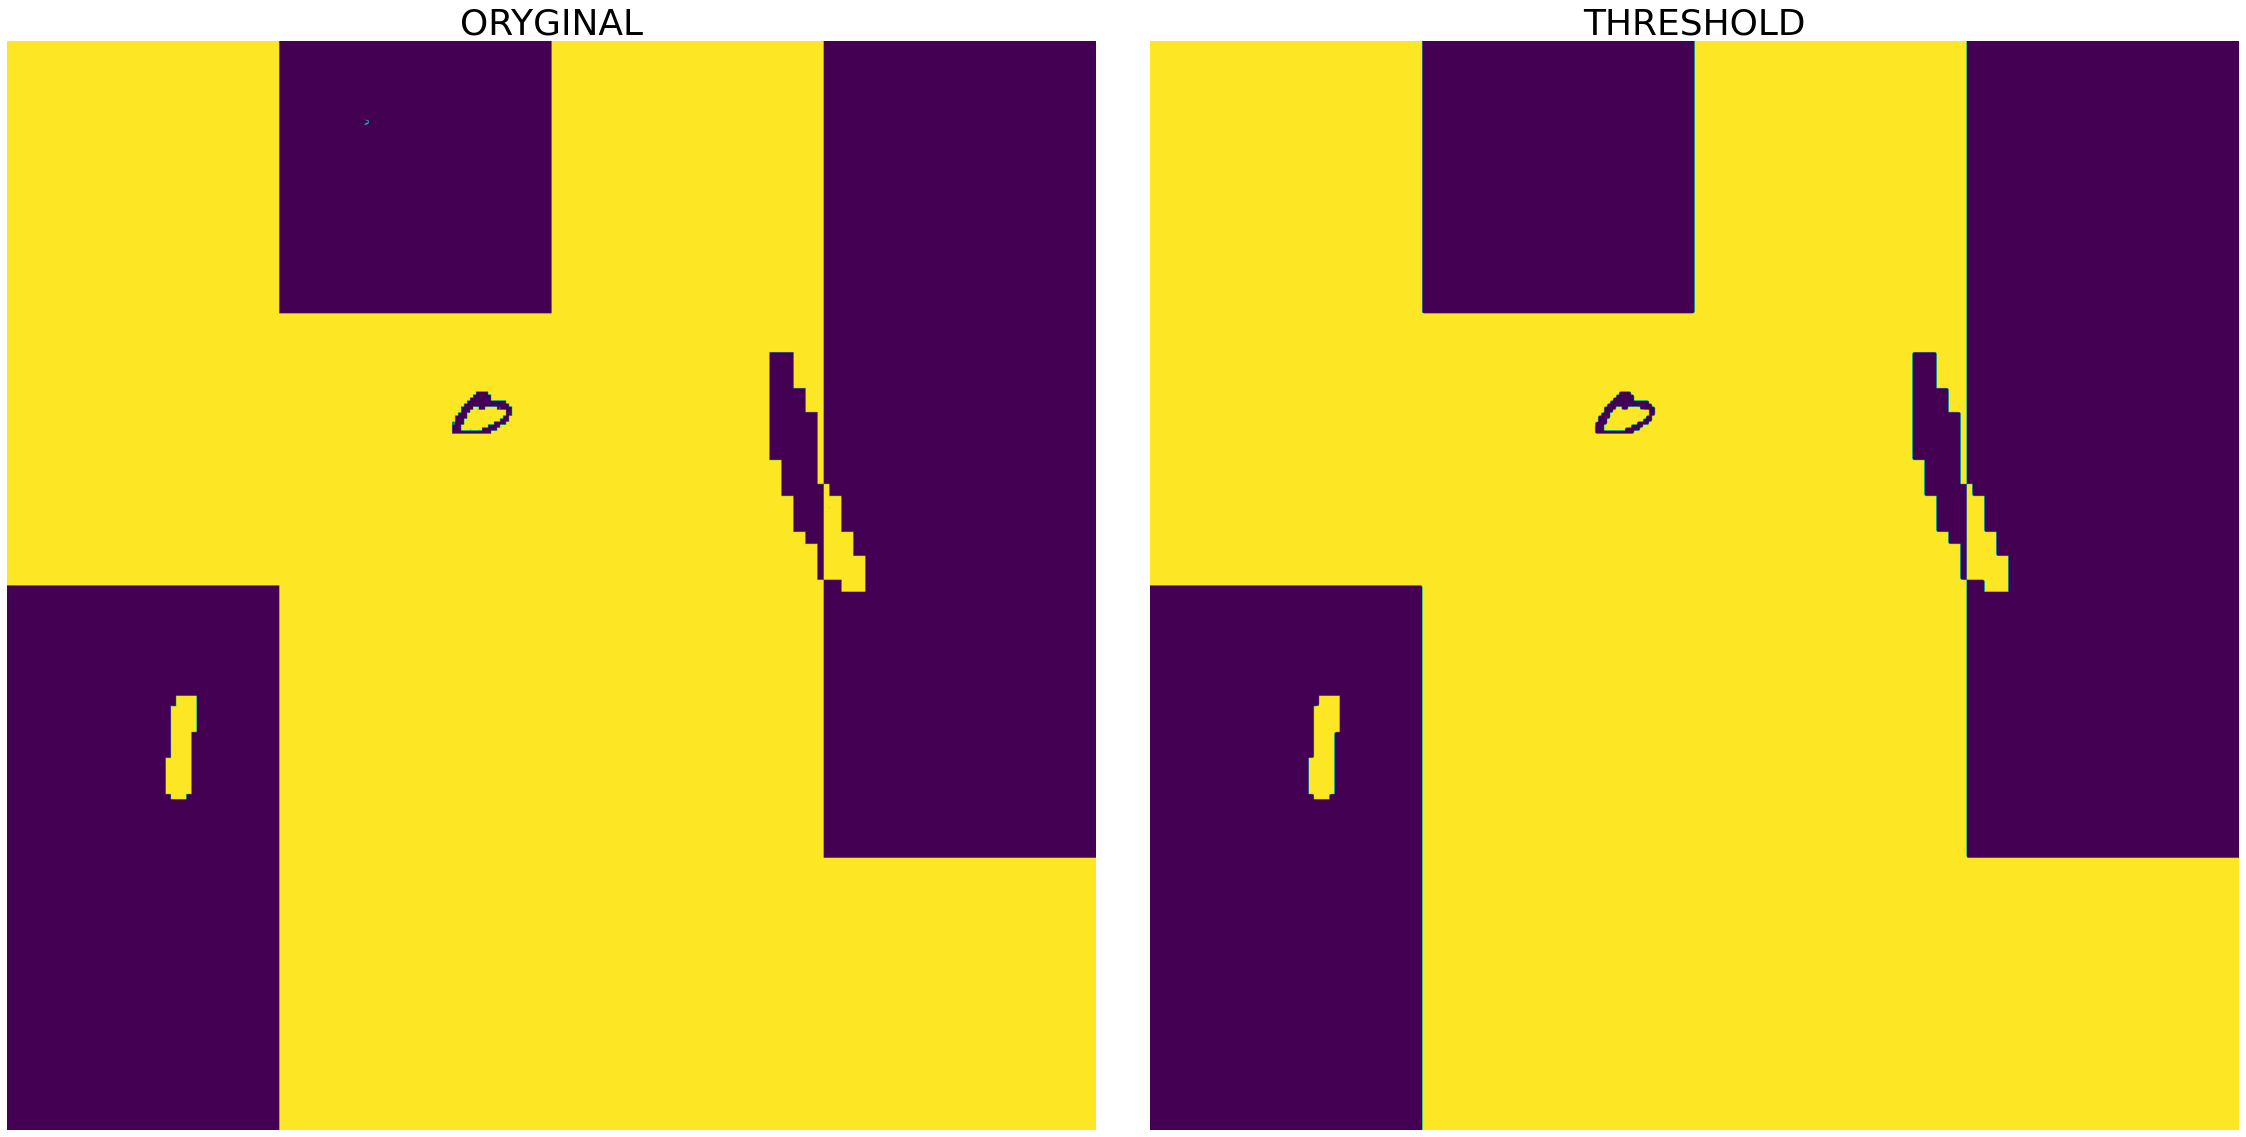

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(40,50))

axes[0].imshow(Img.fromarray(image))
axes[0].axis('off')
axes[0].set_title("ORYGINAL", fontsize=36)
axes[1].imshow(Img.fromarray(thresh))
axes[1].axis('off')
axes[1].set_title("THRESHOLD", fontsize=36)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.axis('off')
plt.show()

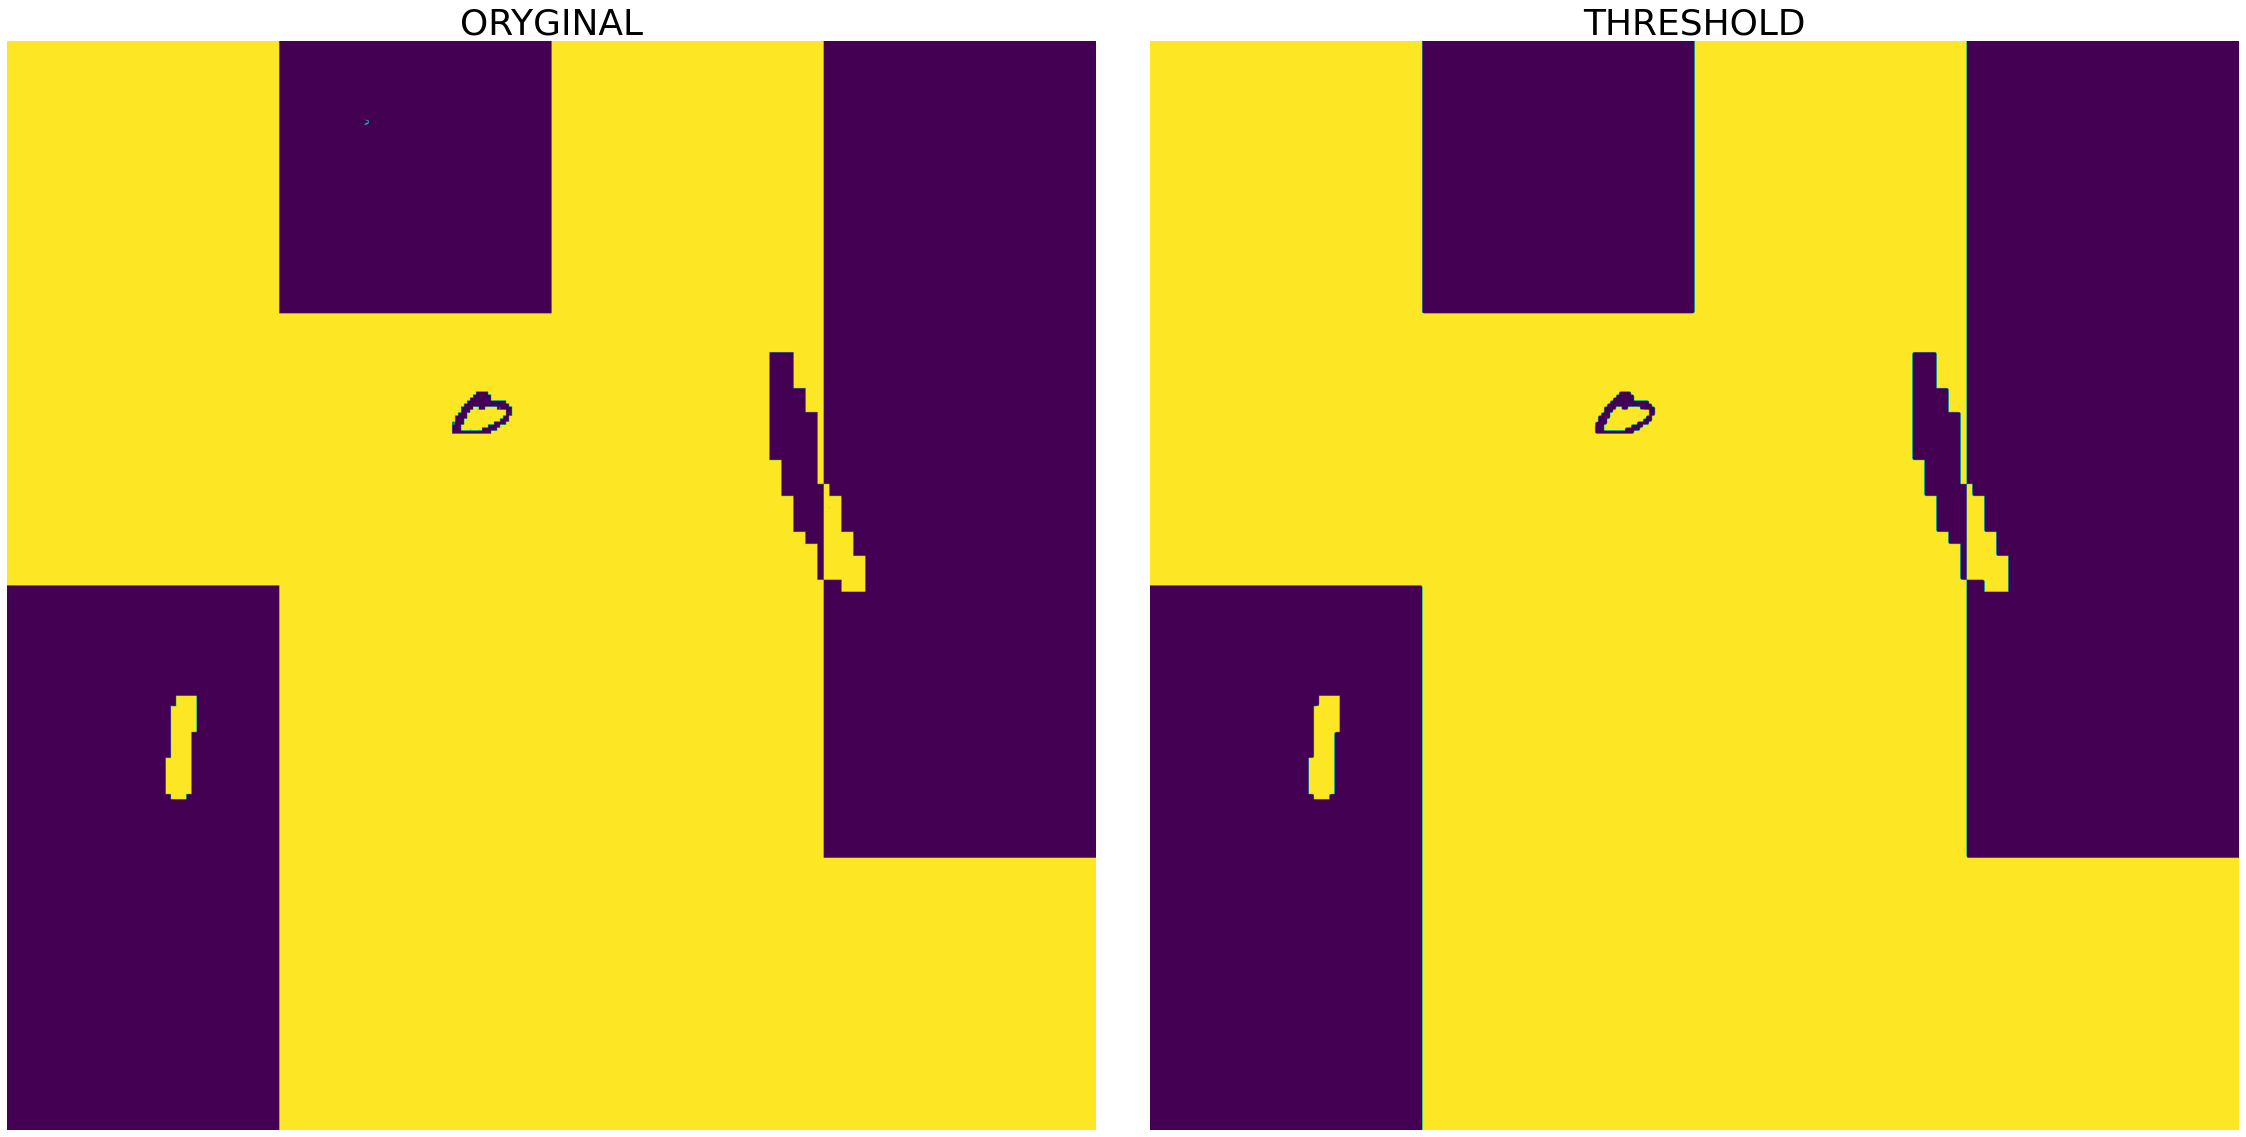

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(40,50))

axes[0].imshow(Img.fromarray(image))
axes[0].axis('off')
axes[0].set_title("ORYGINAL", fontsize=36)
axes[1].imshow(Img.fromarray(thresh))
axes[1].axis('off')
axes[1].set_title("THRESHOLD", fontsize=36)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.axis('off')
plt.show()

In [28]:
labels = measure.label(thresh,background = 0)
mask = np.zeros(thresh.shape, dtype="uint8")

for label in np.unique(labels):
    if label == 0:
        continue

    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
    if numPixels > 300:
        mask = cv2.add(mask, labelMask)

In [29]:
bbox_list = []

cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts)[0]
print(f'Found {len(cnts)} contours / numbers')
backtorgb = cv2.cvtColor(image.astype('float32'), cv2.COLOR_GRAY2RGB)

for (i, c) in enumerate(cnts):
    (x, y, w, h) = cv2.boundingRect(c)
    bbox_list.append([x, y, w, h])
    cv2.rectangle(backtorgb, (x,y), (x+w, y+h), (255,0,0), 5)

print(f'BBoxes coordinates: {bbox_list}')

Found 2 contours / numbers
BBoxes coordinates: [[0, 0, 4000, 4000], [583, 2405, 114, 380]]


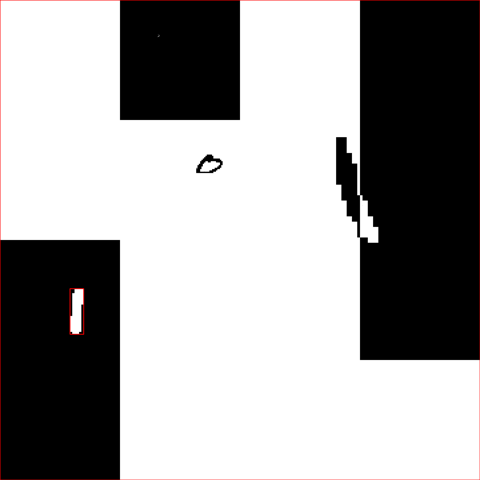

In [30]:
display(Img.fromarray(backtorgb.astype(np.uint8)).resize((480,480)))

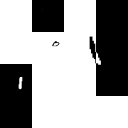

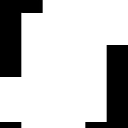

In [31]:
for bbox in bbox_list:
    bbox_img = image[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
    bbox_resized = cv2.resize(bbox_img, (128, 128), interpolation = cv2.INTER_AREA)
    display(Img.fromarray((bbox_resized).astype(np.uint8)))

## Exp

In [32]:
# Noise
from sklearn.datasets import make_blobs
def CreateNoiseImage(input_image):
    global size
    global noise_matrix
    data = make_blobs(n_samples= 2800, n_features= 13, centers= 4, cluster_std =3, random_state=1)
    #plt.figure(figsize=(8,8))
    #plt.scatter(data[0][:,0],data[0][:,1], c = data[1], cmap='rainbow')

    if size==1000:
      data1=(((data[0]-np.min(data[0]))/(np.max(data[0])-np.min(data[0])))*860).astype(int)
    elif size== 500:
      data1=(((data[0]-np.min(data[0]))/(np.max(data[0])-np.min(data[0])))*460).astype(int)
    data1[:,1] += 10
    
    noise_matrix = -1*np.ones((size,size,3))
    for i,j in data1[:,:2]:
        noise_matrix[j,i,:] = -5
    
    import matplotlib.pyplot as plt
    """
    im = plt.imread('../Images/img4.jpg')[:size,:size,:] #[:1000,:1000,:]  # img4.jpg
    plt.figure(figsize=(10,10))
    implot = plt.imshow(im)

    plt.scatter(data1[:,0],data1[:,1], c = data[1], cmap='rainbow')
    plt.axis('off')
    plt.savefig("../Images/img4_noise.jpg",bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()
    """
    fig = plt.figure()
    im = input_image
    plt.figure(figsize=(10,10))
    implot = plt.imshow(im)

    
    plt.scatter(data1[:,0],data1[:,1], c = data[1], cmap='rainbow')
    plt.axis('off')
    plt.savefig("../Images/img4_noise.jpg",bbox_inches='tight',transparent=True, pad_inches=0)
    plt.close()
    out_image = plt.imread("../Images/img4_noise.jpg")
    #plt.show()
    return out_image
#t=CreateNoiseImage(plt.imread('../Images/img4.jpg')[:size,:size,:])

In [33]:
def Calculate_noise(img):
    global width
    global size
    mean_img = img.copy()
    img_transition_value = np.zeros((size//width,size//width))
    for i in range(0,size,width):
        for j in range(0,size,width):
            # got all the points
            t = img[i:i+width,j:j+width,:]
            no_5 = (t==-5).sum()
            #pixel_value = np.max(img[i:i+width,j:j+width,:])
            #if pixel_value==-5:
               # print(pixel_value)
            if no_5 <= 3:              #200 didn't work
                mean_img[i:i+width,j:j+width,:] = 250
            else:
                mean_img[i:i+width,j:j+width,:] = 0 #pixel_value
    #kernel = np.ones((5,5), np.uint8)
    #img_dilation = cv2.dilate(mean_img, kernel, iterations=1) 
    img_dilation = mean_img.copy()
    img_transition_value=np.where(img_dilation<230,0,255) # 230
    #cv2.imwrite("dilated_5_2.jpg",img_transition_value)  # final image look BGR looks black and white
    img_transition_value=img_transition_value[::width,::width,0]
    img_transition_value=np.where(img_transition_value<120,-7,-1) # 230
    return img_transition_value

In [34]:
#img = cv2.imread("../Images/img4.jpg")[:size,:size,:]    #[:1000,:1000,:]
def Calculate_transition_matrix(img):
    global noise_matrix
    global width
    global size
    global noise
    mean_img = img.copy()
    img_transition_value = np.zeros((size//width,size//width))
    for i in range(0,size,width):
        for j in range(0,size,width):
            # got all the points
            pixel_value = np.mean(img[i:i+width,j:j+width,:])
            if pixel_value >210:              #200 didn't work
                mean_img[i:i+width,j:j+width,:] = 250
            else:
                mean_img[i:i+width,j:j+width,:] = 0 #pixel_value
    #kernel = np.ones((5,5), np.uint8)
    #img_dilation = cv2.dilate(mean_img, kernel, iterations=1) 
    img_dilation = mean_img.copy()
    img_transition_value=np.where(img_dilation<230,0,255) # 230
    #cv2.imwrite("dilated_5_2.jpg",img_transition_value)  # final image look BGR looks black and white
    img_transition_value=img_transition_value[::width,::width,0]
    img_transition_value=np.where(img_transition_value<120,-80,-1) # 230 
    
    ## noise
    #i1 = cv2.imread("noise1.PNG")
    #i1=cv2.resize(i1,(size,size))
    #img_transition_value = np.minimum(i2,img_transition_value)
    if noise == True:
      i2=Calculate_noise(noise_matrix)
      img_transition_value = np.minimum(img_transition_value,i2 )
    ##
    #print("final reward")
    #sns.heatmap(img_transition_value)
    #plt.show()
    return img_transition_value

In [35]:
def Calculate_transition_matrix(img):
    temp_img = -10*np.ones(img.shape) # -80
    temp_img[img>20] = -1 
    return temp_img
    

In [36]:
def Sweep(Value, Policy,terminators,transition_value):
    # create transition matrix globally that is not possible since we will create dynamic wall
    New_Value = Value.copy()
    delta = 0
    x,y = Value.shape
    for i in range(x):  # x
        left = 0
        right = 0
        top = 0
        bottom = 0
        for j in range(y):  # y
            # (i,j)  
            if (i,j) in terminators:
                pass
            else:
                same= Value[i,j]
                if i==0:
                    left = same
                else:
                    left = Value[i-1,j]
                if i==x-1:
                    right= same
                else:
                    right = Value[i+1,j]
                if j==0:
                    top= same
                else:
                    top = Value[i,j-1]
                if j==y-1:
                    bottom= same
                else:
                    bottom = Value[i ,j+1]
#                 if (i,j) in red:
#                     transition_reward = -10
#                 else:
#                     transition_reward = -1
                transition_reward = transition_value[i,j]
                total_value = Policy[(y)*i+j,0]*(transition_reward+left) + Policy[(y)*i+j,1]*(transition_reward+right) + Policy[(y)*i+j,2]*(transition_reward+top) + Policy[(y)*i+j,3]*(transition_reward+bottom)
                #print(total_value, New_Value[i,j])
                delta = max(delta, np.abs(total_value- Value[i,j]))
                New_Value[i,j] = total_value    
    #print("Sweep")
    return New_Value, delta

In [37]:
def Improve_Policy(Value, Policy):
    New_Policy = Policy.copy()
    #terminators = (0,1), (0,2),(0,3), (2,0),(2,1),(2,2)
    x,y = Value.shape
    for i in range(x):
        for j in range(y):  # y
            # (i,j)  
            left = 0
            right = 0
            top = 0
            bottom = 0
            same= Value[i,j]
            if i==0:
                left = same
            else:
                left = Value[i-1,j]
            if i==x-1:
                right= same
            else:
                right = Value[i+1,j]
            if j==0:
                top= same
            else:
                top = Value[i,j-1]
            if j==y-1:
                bottom= same
            else:
                bottom = Value[i ,j+1]
            my_list = [left,right, top,bottom]
            max_val = max(my_list)
            my_list = np.array(my_list)
            my_list = (my_list==max_val).astype(int)
            my_list = my_list/np.sum(my_list)
            New_Policy[(y)*i+j,:] = my_list
    #print("Improve_Policy")
    return New_Policy

In [38]:
call =0
def Evaluate_value(Value, Policy,theta,terminators,transition_value):
    Policy = Policy.copy()
    theta = theta
    terminators = terminators.copy()
    Policy = Policy.copy()
    global call
    call += 1
    #terminators = (0,1), (0,2),(0,3), (2,0),(2,1),(2,2)
    delta = float(np.inf)
    while delta> theta:
        delta = 0
        Value, delta = Sweep(Value, Policy, terminators,transition_value)
        #print(delta,theta, delta>theta)
    #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    New_Policy = Improve_Policy(Value, Policy)
    if np.all(Policy==New_Policy):
        #print("Evaluate_value_")
        return Value, New_Policy, theta, terminators
    else:
        # repeat
        #print("Evaluate_value")
        return Evaluate_value(Value, New_Policy,theta, terminators,transition_value)

In [39]:
def Calculate_optimal(Grid_shape,no_actions, terminators,img_mask):
    global verbose
    global img
    global find_optimal_CS
    global Charging_time_CS
    global static_quality_score
    global dynamic_quality_score
    global transition_value
    global actual_dynamic_overhead
    global actual_static_overhead # we can't add charging time before we calculate rem overhead
    x,y = Grid_shape
    State_action = np.ones((x*y,no_actions))*(1/no_actions)  #######  L     R     T     B
    Value = np.zeros((x,y))
    theta = 0.1 #0.001
    
    transition_value = Calculate_transition_matrix(img_mask)
#     for i,j in HOME:
#         transition_value[i,j] = 0  
    for no, (i,j) in enumerate(HOME):
        transition_value[i,j] = 0
        if static_quality_score == True or dynamic_quality_score == True:
          if i != 0:
            # not touching left edge
            transition_value[i,j-1] = min(transition_value[i,j-1], -1*(actual_static_overhead[no]+actual_dynamic_overhead[no])-1)
          if i != 49:
            # not touching right edge
            transition_value[i,j+1] = min(transition_value[i,j+1], -1*(actual_static_overhead[no]+actual_dynamic_overhead[no])-1)
          if j != 0:
            # not touching top edge
            transition_value[i-1,j] = min(transition_value[i-1,j], -1*(actual_static_overhead[no]+actual_dynamic_overhead[no])-1)
          if j != 49:
            # not touching bottom edge
            transition_value[i+1,j] = min(transition_value[i+1,j], -1*(actual_static_overhead[no]+actual_dynamic_overhead[no])-1)
          
#     print("REWARD of each state:-")
#     sns.heatmap(transition_value)
#     plt.show()
#     Value[17,24] = 30
#     terminators.append((17,24))
#     print("terminators",terminators)
    
    #transition_value[25,25] = 1
    #img[25*width-10-70:25*width+10-70,25*width-10:25*width+10,:] = 0
    #Value[HOME] = 0 # No matter how low you make it (-4000) this will become optimal point because everywhere else value is calculated

    l,m,th,tr =Evaluate_value(Value,State_action,79, terminators, transition_value) #l:- value function m:- optimal action
    
    if find_optimal_CS == False and dynamic_quality_score== False:
      print('-'*40)
      print("calculating FUTURE REWARD of each state...")
      print("-"*40)
      print(l)
      print('FUTURE REWARD/Value Functions:-')
#     g2=sns.heatmap(l)
#     g2.tick_params(left=False)  # remove the ticks  #tick_params(left=False)  # remove the ticks
#     plt.tight_layout()
#     plt.show()
    

    if dynamic_quality_score == False and verbose != 0:
      f,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(18,6))
      g1 = sns.heatmap(transition_value,ax=ax1)
      g1.set_ylabel('')
      g1.set_xlabel('')
      g2 = sns.heatmap(l,ax=ax2)
      g2.set_ylabel('')
      g2.set_xlabel('')
      plt.show()
    
    
#     layout1 = cv.Layout(
#     height=500,
#     width=500
#     )
    if static_quality_score == True and dynamic_quality_score == False:
      # 3d plot
      new_value = (l-np.min(l))/(np.max(l)-np.min(l))
      pd.DataFrame(new_value).iplot(kind='surface',) # layout= layout1)
    
    #print("Calculate_optimal")         # 80 for -100 , 9.5 for -10 , 100 for -1000  60 for -80
    return l,m              

In [40]:
def recheck(x,y):
  global HOME
  global optimal_value
  global AGENT
  global dynamic_quality_score
  global actual_dynamic_overhead
  global actual_static_overhead
  global terminators
  global state
  global battery
  global Overhead_time_CS
  global Charging_time_CS
  global no_steps
  global stats_df
  
  index_no = HOME.index((x,y))
  time_taken = -1* optimal_value[AGENT[0],AGENT[1]]
  rem_overhead = max(0,Overhead_time_CS[index_no] - time_taken)
  stats_df.loc[index_no,"CS_pos"] = str((x,y))
  stats_df.loc[index_no,"travel_time"] = time_taken
  stats_df.loc[index_no, "rem_overhead"] = rem_overhead
  stats_df.loc[index_no, "total time"] = time_taken + rem_overhead + Charging_time_CS[index_no]
  if rem_overhead <= 0:
    # means none can be better than this cs.
    # stop
    #print(f"Overhead on the CS is {Overhead_time_CS[index_no]}")
    #print(f"Time taken to reach the CS is {time_taken}")
    #print(f"No of steps is {no_steps}")
    #print(f"Overhead on reaching CS {(x,y)} is: {rem_overhead} thus Total Time: {time_taken + rem_overhead}")
    print(stats_df)
    if battery == True:
      #print(f"REACHED_DEST [{x},{y}] in {no_steps} steps, time taken {-1*optimal_value[AGENT[0],AGENT[1]]} minutes")
      print(f"REACHED_DEST [{x},{y}] in {no_steps} steps, time taken {time_taken + rem_overhead + Charging_time_CS[index_no]} minutes")
    else:
      print(f"REACHED_DEST [{x},{y}] in {no_steps} steps, with reward of {optimal_value[AGENT[0],AGENT[1]]-rem_overhead-Charging_time_CS[index_no]}")
    print('-'*40)
    return
  else:
    # change transition matrix
    #print(f"Overhead on the CS is {Overhead_time_CS[index_no]}")
    #print(f"Time taken to reach the CS is {time_taken}")
    #print(f"No of steps is {no_steps}")
    #print(f"Overhead on reaching CS {(x,y)} is: {rem_overhead} thus Total Time: {time_taken + rem_overhead}")
    #print("Calculating...")
    print(stats_df)
    actual_dynamic_overhead[index_no] = rem_overhead
    actual_static_overhead[index_no]  = Charging_time_CS[index_no]
    state = 112
    """
    Grid_shape = transition_matrix.shape
    no_actions = 4
    
    optimal_value,optimal_policy = Calculate_optimal(Grid_shape,no_actions, terminators,img_mask)
    """

In [41]:
optimal_path = np.zeros((50,50))
collect_pts = []
def trace_path(optimal_value, optimal_policy,initial_pt):
    global optimal_path
    global width 
    global collect_pts
    global dynamic_quality_score
    global Last_CS 
    x,y = initial_pt  # 48,25
    if (x,y) in HOME: #== HOME:
        if dynamic_quality_score == True and (Last_CS != (x,y) or (x,y)== HOME[-1]):
          # we will check once again
          Last_CS = (x,y)
          recheck(x,y)
        else:
          # stop
          print("REACHED HOME")
          return
    if x<0 or x>= 50 or y<0 or y>= 50:
        # stop execution
        return
    # Plot
    a1 = width*y
    b1 = width*x
    a2 = width*y + width
    b2 = width*x + width
    
    #
    policy_index = x*50 + y
    l,r,t,b = optimal_policy[policy_index,:]
    max_index = (l,r,t,b).index(max(l,r,t,b)) # pick the first optimal index
    indexes = [i for i,j in enumerate((l,r,t,b)) if j==max(l,r,t,b)]
    max_index = random.choice(indexes)
    if max_index==0:
        # left
        #cv2.circle(img, ((a1+a2)//2,(b1+b2)//2),3,(0,250,0),2)
        #cv2.line(img,((a1+a2)//2,b1),((a1+a2)//2,b2), (0,0,0),3)
        trace_path(optimal_value, optimal_policy,(x-1,y))
        optimal_path[x-1:x,y:y+1] += 1
    elif max_index==1:
        # right
        #cv2.circle(img, ((a1+a2)//2,(b1+b2)//2),3,(0,250,0),2)
        #cv2.line(img,((a1+a2)//2,b1),((a1+a2)//2,b2), (0,0,0),3)
        trace_path(optimal_value, optimal_policy,(x,y+1))
        optimal_path[x:x+1,y+1:y+2] += 1
    elif max_index==2:
        # top
        #cv2.circle(img, ((a1+a2)//2,(b1+b2)//2),3,(0,250,0),2)
        #cv2.line(img,(a1,(b1+b2)//2),(a2,(b1+b2)//2), (0,0,0),3)
        trace_path(optimal_value, optimal_policy,(x,y-1))
        optimal_path[x:x+1,y-1:y] += 1
    elif max_index==3:
        # bottom 
        #cv2.circle(img, ((a1+a2)//2,(b1+b2)//2),3,(0,250,0),2)
        #cv2.line(img,(a1,(b1+b2)//2),(a2,(b1+b2)//2), (0,0,0),3)
        trace_path(optimal_value, optimal_policy,(x,y+1))
        optimal_path[x:x+1,y+1:y+2] += 1
    else:
        print("ERROR")

In [42]:
def draw_path():
    global optimal_path
    global img
    global width
    global size
    print('calculating')
    Full_matrix = (np.repeat(np.repeat(optimal_path,width,axis=0),width,axis=1)*500).astype(int)
    img = ((np.clip((img - Full_matrix.reshape(size,size,1)).astype(int),0,255)).astype(int)).astype(np.uint8)

In [43]:
# def smart_trace():
#     #print('tracing path..')
#     print("="*80)
#     global optimal_value
#     global optimal_policy
#     global width 
#     global size
#     global battery
    
#     global dynamic_quality_score
#     global actual_dynamic_overhead
#     global Last_CS
#     global no_checked_CS
#     global no_steps
#     global stats_df
#     global Overhead_time_CS
#     global HOME
#     global Charging_time_CS
    
#     if width == 20:
#       w = 10
#     elif width == 10:
#       w = 10
#     T =np.argmax(optimal_policy, axis=1)
#     x_dict = {0:-1,1:1,2:0,3:0}
#     y_dict = {0:0,1:0,2:-1,3:1}
#     x_axis=np.vectorize(x_dict.get)(T)
#     y_axis=np.vectorize(y_dict.get)(T)
#     #f_x ,f_y = HOME
#     in_x, in_y = AGENT
#     no_steps = 0
#     if width == 20:
#       r = 2
#     elif width == 10:
#       r = 3
#     while (in_x,in_y) not in HOME: #in_x != f_x or in_y != f_y:
#         no_steps += 1
#         m = w*in_x
#         l = w*in_y
#         cv2.circle(img, ((2*l+w)//2,(2*m+w)//2),r,(0,255,0),5)
#         new_loc = 50*in_x + in_y
#         in_x += x_axis[new_loc]
#         in_y += y_axis[new_loc]
#         #print("action",x_axis[new_loc],y_axis[new_loc])
#         #print("reached",in_x,in_y)
#         if l<0 or l>999 or m <0 or m>999:
#             print('Not found',(2*l + w),(2*m + w))
#             return

 
#     x,y = in_x, in_y  # 48,25
#     if (x,y) in HOME: #== HOME:
#         if dynamic_quality_score == True and (Last_CS != (x,y)) and no_checked_CS != len(actual_dynamic_overhead):
#           # we will check once again
#           no_checked_CS += 1
#           Last_CS = (x,y)
#           recheck(x,y)
#         else:
#           # stop
#           rem_overhead = 0
#           Charge_t = 0
#           if dynamic_quality_score == True:
#             index_no = HOME.index((x,y))
#             time_taken = -1* optimal_value[AGENT[0],AGENT[1]]
#             rem_overhead = max(0,Overhead_time_CS[index_no] - time_taken)
#             stats_df.loc[index_no,"CS_pos"] = str((x,y))
#             stats_df.loc[index_no,"travel_time"] = time_taken
#             stats_df.loc[index_no, "rem_overhead"] = rem_overhead
#             stats_df.loc[index_no, "total time"] = time_taken + rem_overhead + Charging_time_CS[index_no]
#             Charge_t = Charging_time_CS[index_no]
#             print(stats_df)
#           if battery == True:
#             print(f"REACHED_DEST [{in_x},{in_y}] in {no_steps} steps, time taken {-1*optimal_value[AGENT[0],AGENT[1]]+rem_overhead+Charge_t} minutes")
#           else:
#             print(f"REACHED_DEST [{in_x},{in_y}] in {no_steps} steps, with reward of {optimal_value[AGENT[0],AGENT[1]]-rem_overhead-Charge_t}")
#           print('-'*40)
#           return


In [44]:
def smart_trace():
    #print('tracing path..')
    print("="*80)
    global optimal_value
    global optimal_policy
    global width 
    global size
    global battery
    
    global dynamic_quality_score
    global actual_dynamic_overhead
    global Last_CS
    global no_checked_CS
    global no_steps
    global stats_df
    global Overhead_time_CS
    global HOME
    global Charging_time_CS
    
    if width == 20:
      w = 10
    elif width == 10:
      w = 10
    T =np.argmax(optimal_policy, axis=1)
    x_dict = {0:-1,1:1,2:0,3:0}
    y_dict = {0:0,1:0,2:-1,3:1}
    x_axis=np.vectorize(x_dict.get)(T)
    y_axis=np.vectorize(y_dict.get)(T)
    #f_x ,f_y = HOME
    in_x, in_y = AGENT
    no_steps = 0
    if width == 20:
      r = 2
    elif width == 10:
      r = 3
    while (in_x,in_y) not in HOME: #in_x != f_x or in_y != f_y:
        no_steps += 1
        m = w*in_x
        l = w*in_y
        #-#cv2.circle(img, ((2*l+w)//2,(2*m+w)//2),r,(0,255,0),5)
        new_loc = 50*in_x + in_y
        in_x += x_axis[new_loc]
        in_y += y_axis[new_loc]
        #print("action",x_axis[new_loc],y_axis[new_loc])
        #print("reached",in_x,in_y)
        if l<0 or l>999 or m <0 or m>999:
            print('Not found',(2*l + w),(2*m + w))
            return

 
    x,y = in_x, in_y  # 48,25
    if (x,y) in HOME: #== HOME:
        if dynamic_quality_score == True and (Last_CS != (x,y)) and no_checked_CS != len(actual_dynamic_overhead):
          # we will check once again
          no_checked_CS += 1
          Last_CS = (x,y)
          recheck(x,y)
        else:
          # stop
          rem_overhead = 0
          Charge_t = 0
          if dynamic_quality_score == True:
            index_no = HOME.index((x,y))
            time_taken = -1* optimal_value[AGENT[0],AGENT[1]]
            rem_overhead = max(0,Overhead_time_CS[index_no] - time_taken)
            stats_df.loc[index_no,"CS_pos"] = str((x,y))
            stats_df.loc[index_no,"travel_time"] = time_taken
            stats_df.loc[index_no, "rem_overhead"] = rem_overhead
            stats_df.loc[index_no, "total time"] = time_taken + rem_overhead + Charging_time_CS[index_no]
            Charge_t = Charging_time_CS[index_no]
            print(stats_df)
          if battery == True:
            print(f"REACHED_DEST [{in_x},{in_y}] in {no_steps} steps, time taken {-1*optimal_value[AGENT[0],AGENT[1]]+rem_overhead+Charge_t} minutes")
          else:
            print(f"REACHED_DEST [{in_x},{in_y}] in {no_steps} steps, with reward of {optimal_value[AGENT[0],AGENT[1]]-rem_overhead-Charge_t}")
          print('-'*40)
          return


In [45]:
import time

In [46]:
def Calculate_Cost(index):
    global drag
    global state
    global HOME
    global AGENT
    global optimal_value
    global img
    global Grid_shape
    global no_action
    global terminators
    global optimal_path
    global width
    global size
    global optimal_policy
    global time_limit
    
    global dj
    
    img_mask = dj #-#cv2.imread("img4.jpg")[:size,:size,:]
    terminators = [(index[0],index[1])]
    HOME = terminators
    v,p= Calculate_optimal(Grid_shape,no_actions, terminators,img_mask)
    return v,p

In [47]:
# called_No = 0
# x1 = 0
# y1 = 0
# def Optimize_CS(image):
#     global called_No 
#     global non_path_reward  #-80
#     global tile_size
#     global x1, y1
#     List_indices = []
#     List_costs = []
    
#     img_mask = image #-#cv2.imread("img4.jpg")[:size,:size,:]
#     transition_value =image #-# Calculate_transition_matrix(img_mask)
#     """
#     HOME = [(3,3)]
#     for i,j in HOME:
#         transition_value[i,j] = 0
#     """
#     mask = transition_value> non_path_reward+2
#     #print(np.where(mask==1))
#     # pick tile_size which can divide 50 like 10/50/2 etc
#     no_subcell = 2

#     #tile_size = 16
#     if called_No == 0:
#         # first time     
#         x1 = 0
#         y1 = 0
#     else:
#         tile_size = 8
        
        
#     for i in range(0,no_subcell):
#         for j in range(0,no_subcell):
#             # (i,j)
#             # pick su
#             x,y = np.where(mask[x1+ i*tile_size: x1+ i*tile_size+tile_size, y1+ j*tile_size:y1 + j*tile_size+tile_size])
#             x =  (i*tile_size) + x
#             y =  (j*tile_size) + y
#             my_list = list(zip(x,y))
#             if my_list == []:
#                 print("no road here")
#             else:
#                 print(my_list)
#                 length = len(my_list)
#                 if length %2 != 0:
#                     # odd no of terms
#                     middle = my_list[(length-1)//2]
#                 else:
#                     # even no of terms
#                     middle = my_list[(length//2) -1]
#                 temp_transition_value = (transition_value[i*tile_size: i*tile_size+tile_size, j*tile_size: j*tile_size+tile_size]).copy()
#                 print(f"Calculating cost for {middle}")
#                 temp_transition_value[middle[0]-(i*tile_size),middle[1]-(j*tile_size)] = 10
#                 plt.figure(figsize=(3,2))
#                 sns.heatmap(temp_transition_value)
#                 plt.show()
                
#                 List_indices.append(middle)
#                 v,p = Calculate_Cost(middle)
#                 cost = np.sum(v[mask])
#                 List_costs.append(cost)
#                 #print(np.random.choice(my_list, size=8))
#                 print(middle,"=",cost)
#             print("#"*80)
#     print(List_indices)
#     print("+"*40)
#     print(List_costs)
#     print("+"*40)
#     print("Optimal CS location")
#     print(List_indices[List_costs.index(max(List_costs))], max(List_costs))
#     Calculate_Cost(List_indices[List_costs.index(max(List_costs))])
    
#     #-#
#     a,b = List_indices[List_costs.index(max(List_costs))] # indices of max cost
#     if a> x1 + tile_size:
#         x1 += tile_size 
#     if b > y1 + tile_size:
#         y1 += tile_size
#     called_No += 1
#     if called_No == 2:
#         return [List_indices[List_costs.index(max(List_costs))]]
#     else:
#         return Optimize_CS(image)

In [48]:

def Optimize_CS(image):
    global verbose
    global called_No 
    global non_path_reward  #-80
    global tile_size
    global x1, y1
    List_indices = []
    List_costs = []
    
    img_mask = image #-#cv2.imread("img4.jpg")[:size,:size,:]
    transition_value =image #-# Calculate_transition_matrix(img_mask)
    """
    HOME = [(3,3)]
    for i,j in HOME:
        transition_value[i,j] = 0
    """
    mask = transition_value> non_path_reward+2
    #print(np.where(mask==1))
    # pick tile_size which can divide 50 like 10/50/2 etc
    no_subcell = 2

    tile_size = 16
    if called_No == 0:
        # first time     
        x1 = 0
        y1 = 0
    else:
        tile_size = 8
    for i in range(0,no_subcell):
        for j in range(0,no_subcell):
            # (i,j)
            # pick su
            x,y = np.where(mask[x1+ i*tile_size: x1+ i*tile_size+tile_size, y1+ j*tile_size:y1 + j*tile_size+tile_size])
            x =  (i*tile_size) + x # since we have 2d aray flattended to 1d
            y =  (j*tile_size) + y
            my_list = list(zip(x,y))
            if my_list == []:
                if verbose != 0:
                    print("no road here")
            else:
                if verbose != 0:
                    print("this is road")
                    print([(x1+i,y1+j) for i,j in my_list])
                length = len(my_list)
                if length %2 != 0:
                    # odd no of terms
                    middle = my_list[(length-1)//2]
                else:
                    # even no of terms
                    middle = my_list[(length//2) -1]
                temp_transition_value = (transition_value[x1 + i*tile_size: x1 + i*tile_size+tile_size, y1 + j*tile_size: y1 + j*tile_size+tile_size]).copy() # picking a 1/4th for display
                if verbose != 0:
                    print(f"Calculating cost for {middle[0]+x1, middle[1]+y1}")
                temp_transition_value[middle[0]-(i*tile_size),middle[1]-(j*tile_size)] = 10 #mapping 1d back to 2d
                if verbose != 0:
                    plt.figure(figsize=(3,2))
                    sns.heatmap(temp_transition_value)
                    plt.show()
                
                List_indices.append(middle)
                v,p = Calculate_Cost(middle)
                if verbose != 0:
                    print(mask.shape, v.shape)
                cost = np.sum(v[mask])
                List_costs.append(cost)
                #print(np.random.choice(my_list, size=8))
                if verbose != 0:
                    print(middle[0]+x1 , middle[1]+y1,"=",cost)
            if verbose != 0:
                print("#"*80)
    if verbose != 0:
        print([(x1+i,y1+j) for i,j in List_indices])
        print("+"*40)
        print(List_costs)
        print("+"*40)
        print("Optimal CS location")
    t = List_indices[List_costs.index(max(List_costs))]
    if verbose != 0:
        print(t[0]+x1, t[1]+ y1,":", max(List_costs))
    Calculate_Cost(List_indices[List_costs.index(max(List_costs))])
    
    #-#
    a,b = List_indices[List_costs.index(max(List_costs))] # indices of max cost
    if a> x1 + tile_size:
        x1 += tile_size 
    if b > y1 + tile_size:
        y1 += tile_size
    called_No += 1
    if called_No == 2:
        return [List_indices[List_costs.index(max(List_costs))]]
    else:
        return Optimize_CS(image)

In [49]:
non_path_reward = -80 #-80
tile_size = 10
#
size =  32 #1000 #1000 #500
width= 1
noise = False
battery = False
find_optimal_CS = True
static_quality_score = False
dynamic_quality_score = False
demo = False
##############################
tile_size = 16 #-#
drag = False
Last_CS = (-100,-100) # something which is not in 50*50
HOME =  [] #0
AGENT = 0
Grid_shape = (32,32) #-#(20,20) #(50,50) #(100,100) # later set automatically
no_actions = 4
terminatos = []
optimal_path = np.zeros((50,50))
non_path_reward = -80
#################################
if size== 1000:
  width = 20
elif size==500:
  width = 10
w = 10

In [50]:
#!pip install plotly
#!pip install cufflinks
from plotly import __version__
print(__version__)
import cufflinks as cv
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected=True)
cv.go_offline()
#pd.DataFrame(new_value).iplot(kind='surface',)

5.6.0


In [51]:
# verbose= 0
# for bbox in bbox_list:
#     bbox_img = image[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
#     bbox_resized = cv2.resize(bbox_img, (32,32), interpolation = cv2.INTER_AREA)
    
#     # bbox_resized is my Image 
#     dj = bbox_resized
#     called_No = 0
#     x1 = 0
#     y1 = 0
#     print("Got Value:")
#     HOME = Optimize_CS(bbox_resized)
#     # Calculate path cost
#     img_mask = bbox_resized
#     optimal_value,optimal_policy = Calculate_optimal(Grid_shape,no_actions, HOME,img_mask)
#     if verbose != 0:
#         sns.heatmap(optimal_value)
#         plt.show()
#         new_value = (optimal_value-np.min(optimal_value))/(np.max(optimal_value)-np.min(optimal_value))
#         pd.DataFrame(new_value).iplot(kind='surface',)
#     print(optimal_value[0,0], optimal_value[-1,0], optimal_value[0,-1], optimal_value[-1,-1], "sum: ",optimal_value[0,0]+ optimal_value[-1,0]+optimal_value[0,-1]+ optimal_value[-1,-1] )
#     #break
#     """
#     #AGENT
#     FROM = [(0,0),(31,0),(0,31),(31,31)]
#     total_sum = 0
#     for i in range(4):
#         AGENT = FROM[i]

#         #smart_trace()
#         new_value = (optimal_value-np.min(optimal_value))/(np.max(optimal_value)-np.min(optimal_value))
#         pd.DataFrame(new_value).iplot(kind='surface',)
#     print("Net")
#     print(total_sum)
#     """
    
        

#     display(Img.fromarray((bbox_resized).astype(np.uint8)))
#     print("="*40)

In [52]:
print("Done")

Done


In [53]:
called_No = 0
verbose = 0
dj = 0
optimal_policy= 0
def get_pieces(img_path):
    global called_No 
    global verbose 
    global dj
    global optimal_policy
    global AGENT
    
    image = cv2.imread(img_path, 0)
    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    labels = measure.label(thresh,background = 0)
    mask = np.zeros(thresh.shape, dtype="uint8")

    for label in np.unique(labels):
        if label == 0:
            continue

        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        if numPixels > 300:
            mask = cv2.add(mask, labelMask)
    
    bbox_list = []

    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = contours.sort_contours(cnts)[0]
    print(f'Found {len(cnts)} contours / numbers')
    backtorgb = cv2.cvtColor(image.astype('float32'), cv2.COLOR_GRAY2RGB)

    for (i, c) in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        bbox_list.append([x, y, w, h])
        cv2.rectangle(backtorgb, (x,y), (x+w, y+h), (255,0,0), 5)

    print(f'BBoxes coordinates: {bbox_list}')
    
    verbose= 0
    for bbox in bbox_list:
        bbox_img = image[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
        bbox_resized = cv2.resize(bbox_img, (32,32), interpolation = cv2.INTER_AREA)

        # bbox_resized is my Image 
        dj = bbox_resized
        called_No = 0
        x1 = 0
        y1 = 0
        #print("Got Value:")
        HOME = Optimize_CS(bbox_resized)
        # Calculate path cost
        img_mask = bbox_resized
        optimal_value,optimal_policy = Calculate_optimal(Grid_shape,no_actions, HOME,img_mask)
        """
        for k in range(2):
            for t in range(2):
                t1= 0
                t2 = 0
                if k==1:
                    t1 = -1 
                if t == 1:
                    t2 = -1
                AGENT = (t1,t2)
                smart_trace()
        """
        if verbose != 0:
            sns.heatmap(optimal_value)
            plt.show()
            new_value = (optimal_value-np.min(optimal_value))/(np.max(optimal_value)-np.min(optimal_value))
            pd.DataFrame(new_value).iplot(kind='surface',)
        print(round(optimal_value[0,0],2), round(optimal_value[-1,0],2), round(optimal_value[0,-1],2), round(optimal_value[-1,-1],2), "sum: ", round((optimal_value[0,0]+ optimal_value[-1,0]+optimal_value[0,-1]+ optimal_value[-1,-1]),2) )
        #break
        """
        #AGENT
        FROM = [(0,0),(31,0),(0,31),(31,31)]
        total_sum = 0
        for i in range(4):
            AGENT = FROM[i]

            #smart_trace()
            new_value = (optimal_value-np.min(optimal_value))/(np.max(optimal_value)-np.min(optimal_value))
            pd.DataFrame(new_value).iplot(kind='surface',)
        print("Net")
        print(total_sum)
        """



        display(Img.fromarray((bbox_resized).astype(np.uint8)))
        print("="*40)

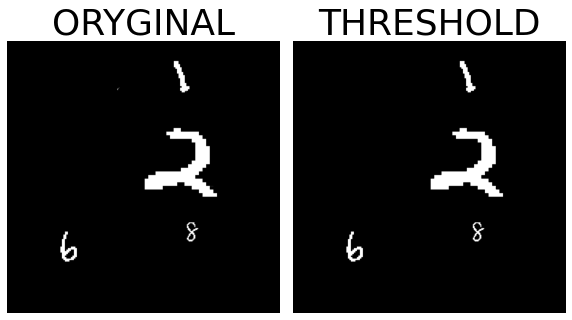

Found 4 contours / numbers
BBoxes coordinates: [[782, 2807, 242, 440], [2017, 1290, 1060, 1007], [2444, 308, 230, 460], [2634, 2672, 168, 280]]
-90.0 -81.0 -188.0 -80.0 sum:  -439.0


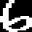

-108.0 -82.0 -100.0 -44.0 sum:  -334.0


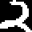

-26.0 -160.0 -225.0 -61.0 sum:  -472.0


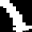

-45.0 -60.0 -122.0 -151.0 sum:  -378.0


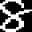

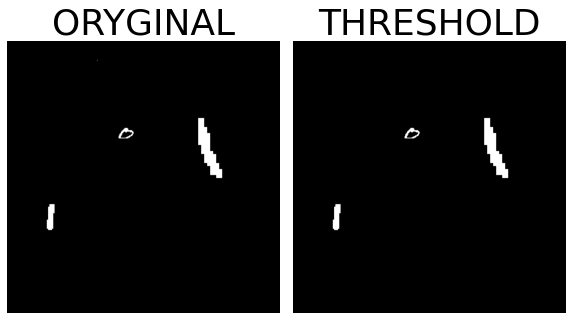

Found 3 contours / numbers
BBoxes coordinates: [[583, 2405, 114, 380], [1635, 1288, 220, 154], [2801, 1143, 352, 880]]
-98.0 -44.0 -27.0 -89.0 sum:  -258.0


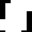

-134.0 -35.0 -108.0 -117.0 sum:  -394.0


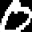

-26.0 -179.0 -243.0 -36.0 sum:  -484.0


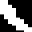

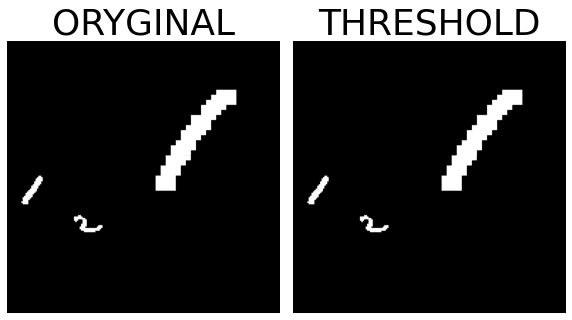

Found 3 contours / numbers
BBoxes coordinates: [[208, 1988, 315, 420], [980, 2565, 420, 252], [2177, 729, 1184, 1480]]
-251.0 -44.0 -36.0 -224.0 sum:  -555.0


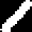

-44.0 -125.0 -209.0 -87.0 sum:  -465.0


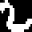

-224.0 -35.0 -27.0 -252.0 sum:  -538.0


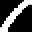

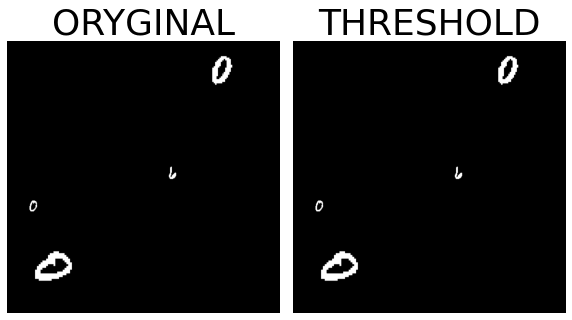

Found 4 contours / numbers
BBoxes coordinates: [[329, 2352, 112, 160], [411, 3096, 540, 432], [2371, 1857, 108, 180], [3007, 237, 294, 420]]
-99.0 -54.0 -80.0 -143.0 sum:  -376.0


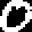

-152.0 -53.0 -99.0 -125.0 sum:  -429.0


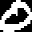

-72.0 -54.0 -197.0 -107.0 sum:  -430.0


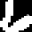

-114.0 -70.0 -64.0 -169.0 sum:  -417.0


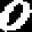

In [54]:
for i in range(4):
    image = cv2.imread(paths2[i])
    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    fig, axes = plt.subplots(1, 2, figsize=(10,12))

    axes[0].imshow(Img.fromarray(image))
    axes[0].axis('off')
    axes[0].set_title("ORYGINAL", fontsize=36)
    axes[1].imshow(Img.fromarray(thresh))
    axes[1].axis('off')
    axes[1].set_title("THRESHOLD", fontsize=36)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.axis('off')
    plt.show()
    get_pieces(paths2[i])